# Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy as stats
import seaborn as sns
import zipfile
import sqlite3

# Opening data files, cleaning and assigning to dataframes so team is working from the same dataset

In [2]:
movie_gross_data = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
print(movie_gross_data)

                                            title      studio  domestic_gross  \
0                                     Toy Story 3          BV     415000000.0   
1                      Alice in Wonderland (2010)          BV     334200000.0   
2     Harry Potter and the Deathly Hallows Part 1          WB     296000000.0   
3                                       Inception          WB     292600000.0   
4                             Shrek Forever After        P/DW     238700000.0   
...                                           ...         ...             ...   
3382                                    The Quake       Magn.          6200.0   
3383                  Edward II (2018 re-release)          FM          4800.0   
3384                                     El Pacto        Sony          2500.0   
3385                                     The Swan  Synergetic          2400.0   
3386                            An Actor Prepares       Grav.          1700.0   

     foreign_gross  year  


In [3]:
movie_popularity = pd.read_csv("zippedData/tmdb.movies.csv.gz")
print(movie_popularity)

       Unnamed: 0            genre_ids      id original_language  \
0               0      [12, 14, 10751]   12444                en   
1               1  [14, 12, 16, 10751]   10191                en   
2               2        [12, 28, 878]   10138                en   
3               3      [16, 35, 10751]     862                en   
4               4        [28, 878, 12]   27205                en   
...           ...                  ...     ...               ...   
26512       26512             [27, 18]  488143                en   
26513       26513             [18, 53]  485975                en   
26514       26514         [14, 28, 12]  381231                en   
26515       26515      [10751, 12, 28]  366854                en   
26516       26516             [53, 27]  309885                en   

                                     original_title  popularity release_date  \
0      Harry Potter and the Deathly Hallows: Part 1      33.533   2010-11-19   
1                      

In [4]:
#cleaning 
movie_gross_data = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
movie_gross_data["foreign_gross"].fillna(0, inplace = True)
movie_gross_data["domestic_gross"].fillna(0, inplace = True)
movie_gross_data.dropna(inplace = True)
print(movie_gross_data)

                                            title      studio  domestic_gross  \
0                                     Toy Story 3          BV     415000000.0   
1                      Alice in Wonderland (2010)          BV     334200000.0   
2     Harry Potter and the Deathly Hallows Part 1          WB     296000000.0   
3                                       Inception          WB     292600000.0   
4                             Shrek Forever After        P/DW     238700000.0   
...                                           ...         ...             ...   
3382                                    The Quake       Magn.          6200.0   
3383                  Edward II (2018 re-release)          FM          4800.0   
3384                                     El Pacto        Sony          2500.0   
3385                                     The Swan  Synergetic          2400.0   
3386                            An Actor Prepares       Grav.          1700.0   

     foreign_gross  year  


In [5]:
#cleaning 
movie_gross_data["domestic_gross"].replace(',','', regex = True, inplace = True)
movie_gross_data["foreign_gross"].replace(',','', regex = True, inplace = True)

In [6]:
movie_gross_data["total_gross"] = movie_gross_data["foreign_gross"].astype(float) + movie_gross_data["domestic_gross"].astype(float)
print(movie_gross_data)

                                            title      studio  domestic_gross  \
0                                     Toy Story 3          BV     415000000.0   
1                      Alice in Wonderland (2010)          BV     334200000.0   
2     Harry Potter and the Deathly Hallows Part 1          WB     296000000.0   
3                                       Inception          WB     292600000.0   
4                             Shrek Forever After        P/DW     238700000.0   
...                                           ...         ...             ...   
3382                                    The Quake       Magn.          6200.0   
3383                  Edward II (2018 re-release)          FM          4800.0   
3384                                     El Pacto        Sony          2500.0   
3385                                     The Swan  Synergetic          2400.0   
3386                            An Actor Prepares       Grav.          1700.0   

     foreign_gross  year   

Using zipfile to unzip imdb database and creating connection to the database

In [7]:
with zipfile.ZipFile("zippedData/im.db.zip", "r") as zObject:
        zObject.extractall()

In [8]:
conn = sqlite3.connect("im.db")
cur = conn.cursor()

Ensuring database is pulling correctly by running simple queries, analyzing columns to see where movie_basics and movie_ratings tables join

In [9]:
pd.read_sql("""
SELECT *
FROM movie_basics
GROUP BY genres
;
""", conn).head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0187902,How Huang Fei-hong Rescued the Orphan from the...,How Huang Fei-hong Rescued the Orphan from the...,2011,NaN,None
1,tt0364201,Aman Ke Farishtey,Aman Ke Farishtey,2016,137.0,Action
2,tt6848590,Moonshine Meat Market Mayhem,Moonshine Meat Market Mayhem,2016,NaN,"Action,Adult,Comedy"
3,tt10097958,Gripped: Climbing Killer Pillar,Gripped: Climbing Killer Pillar,2019,NaN,"Action,Adventure"
4,tt0448694,Puss in Boots,Puss in Boots,2011,90.0,"Action,Adventure,Animation"


In [10]:
pd.read_sql("""
SELECT *
FROM movie_ratings
;
""", conn).head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


# Question: What movies are doing well at the box office by genre and ratings? 

Below is the query I ran to find join the movie_ratings and movie_basics tables from the imdb database to pull genres and movie ratings. I wanted to pull genres with a rating of 8.4 or higher and to exclude those rows that have a null value for genre. I wanted the results in descendingorder so I have ratings of 10 at the top. I then made the query into a dataframe so I can graph it and group the genres so I have a more concise and accurate dataset.

In [11]:
q = """
SELECT averagerating as avg_rating, genres, numvotes
FROM movie_ratings
JOIN movie_basics
    USING (movie_id)
WHERE averagerating >= 8.5
AND numvotes > 30
AND genres IS NOT NULL
ORDER BY avg_rating DESC
;
"""
high_ratings = pd.read_sql(q, conn)
print(high_ratings)

      avg_rating                       genres  numvotes
0            9.9                        Drama       417
1            9.8            Documentary,Music        45
2            9.7                  Documentary        32
3            9.7                  Documentary        48
4            9.7                  Documentary        72
...          ...                          ...       ...
1052         8.5                        Drama       336
1053         8.5      Action,Adventure,Sci-Fi    670926
1054         8.5  Biography,Documentary,Music        73
1055         8.5                        Drama        78
1056         8.5                  Documentary        39

[1057 rows x 3 columns]


In [12]:
high_ratings = high_ratings[high_ratings["genres"].str.contains("None") == False]

data_for_analysis_by_rating = high_ratings.groupby(by="genres", as_index=False).mean()

#data_for_analysis_by_rating_sort = data_for_analysis_by_rating.sort_values(by = 'avg_rating', ascending=False)

data_for_analysis_by_rating.sort_values(by="avg_rating", ascending=False, inplace = True)

print(data_for_analysis_by_rating)

                         genres  avg_rating  numvotes
79         Comedy,Drama,Musical         9.5     354.0
12    Action,Comedy,Documentary         9.4     114.0
119   Documentary,History,Sport         9.4      43.0
44             Adventure,Family         9.4     797.0
102      Crime,Mystery,Thriller         9.3   18470.0
..                          ...         ...       ...
137       Drama,Fantasy,Musical         8.5     100.0
147        Drama,Mystery,Sci-Fi         8.5      31.0
16         Action,Crime,Mystery         8.5    8560.0
110     Documentary,Drama,Sport         8.5      99.0
45   Adventure,Mystery,Thriller         8.5      42.0

[171 rows x 3 columns]


Pulling top 30 rows from the dataframe as these are the most relevant to helping support my original question 

In [13]:
top_20 = data_for_analysis_by_rating.iloc[:20]

print(top_20)


                            genres  avg_rating      numvotes
79            Comedy,Drama,Musical    9.500000    354.000000
12       Action,Comedy,Documentary    9.400000    114.000000
119      Documentary,History,Sport    9.400000     43.000000
44                Adventure,Family    9.400000    797.000000
102         Crime,Mystery,Thriller    9.300000  18470.000000
8     Action,Biography,Documentary    9.300000     35.000000
46                 Adventure,Sport    9.200000     72.000000
19       Action,Documentary,Family    9.200000     44.000000
39   Adventure,Documentary,Western    9.200000     73.000000
77            Comedy,Drama,Fantasy    9.200000     32.000000
92                   Comedy,Sci-Fi    9.200000     43.000000
74      Comedy,Documentary,History    9.200000   1015.000000
163                Mystery,Romance    9.200000     76.000000
138                  Drama,History    9.150000   3457.500000
124          Documentary,Music,War    9.150000    386.500000
108        Documentary,D

In [14]:
top_20_no_numvotes = top_20.drop(["numvotes"], axis = 1)

print(top_20_no_numvotes)

                            genres  avg_rating
79            Comedy,Drama,Musical    9.500000
12       Action,Comedy,Documentary    9.400000
119      Documentary,History,Sport    9.400000
44                Adventure,Family    9.400000
102         Crime,Mystery,Thriller    9.300000
8     Action,Biography,Documentary    9.300000
46                 Adventure,Sport    9.200000
19       Action,Documentary,Family    9.200000
39   Adventure,Documentary,Western    9.200000
77            Comedy,Drama,Fantasy    9.200000
92                   Comedy,Sci-Fi    9.200000
74      Comedy,Documentary,History    9.200000
163                Mystery,Romance    9.200000
138                  Drama,History    9.150000
124          Documentary,Music,War    9.150000
108        Documentary,Drama,Music    9.133333
93                    Comedy,Sport    9.100000
123        Documentary,Music,Sport    9.100000
40                 Adventure,Drama    9.100000
140           Drama,Horror,Mystery    9.100000


# Visualization to learn more about the data and form recommendation

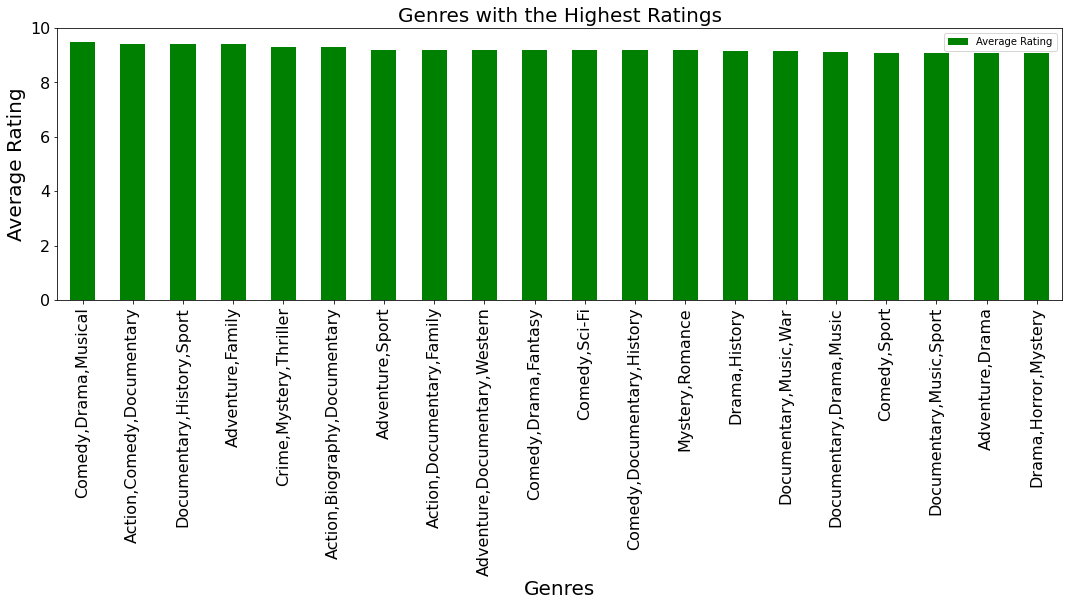

In [15]:
#plt.figure(figsize=(18, 5))
#plt.bar(top_30["genres"], top_30["avg_rating"], color = "b")

top_20_no_numvotes.plot("genres", kind="bar", figsize = (18,5), color = "g")
plt.xlabel("Genres", fontsize = 20)
plt.xticks(rotation = 90, fontsize = 16)
plt.ylabel("Average Rating", fontsize = 20)
plt.yticks(range(0,11,2), fontsize = 16)
plt.title("Genres with the Highest Ratings", fontsize = 20)
plt.legend(labels=['Average Rating'])
plt.show()

# Information about genres with the lowest ratings to help support our recommendation

In [16]:
q2 = """
SELECT averagerating as avg_rating, genres, numvotes
FROM movie_ratings
JOIN movie_basics
    USING (movie_id)
WHERE averagerating <= 2
AND numvotes > 30
AND genres IS NOT NULL
ORDER BY avg_rating DESC
;
"""
low_ratings = pd.read_sql(q2, conn)
print(low_ratings)

     avg_rating                  genres  numvotes
0           2.0                  Comedy       164
1           2.0  Action,Horror,Thriller       156
2           2.0         Sci-Fi,Thriller        65
3           2.0   Comedy,Family,Fantasy        57
4           2.0                   Crime       230
..          ...                     ...       ...
294         1.0    Comedy,Drama,Romance       440
295         1.0          Comedy,Fantasy       674
296         1.0                   Drama       510
297         1.0            Comedy,Drama        96
298         1.0                   Drama       223

[299 rows x 3 columns]


In [17]:
low_ratings = low_ratings[low_ratings["genres"].str.contains("None") == False]

data_for_analysis_by_rating_low = low_ratings.groupby(by="genres", as_index=False).mean()

#data_for_analysis_by_rating_sort_low = data_for_analysis_by_rating_low.sort_values(by = 'avg_rating', ascending=True)

data_for_analysis_by_rating_low.sort_values(by="avg_rating", ascending=True, inplace = True)

print(data_for_analysis_by_rating_low)

                        genres  avg_rating  numvotes
72                Drama,Family         1.0     307.0
36  Adventure,Biography,Comedy         1.0     352.0
35  Adventure,Animation,Family         1.0     112.0
86     Fantasy,Mystery,Romance         1.0     520.0
38     Adventure,Drama,Romance         1.1      55.0
..                         ...         ...       ...
64                       Crime         2.0     145.5
31                Adult,Horror         2.0     128.0
25               Action,Horror         2.0     373.0
61      Comedy,Musical,Romance         2.0      54.0
45                   Biography         2.0     148.0

[103 rows x 3 columns]


In [18]:
top_20_low = data_for_analysis_by_rating_low.iloc[:20]

print(top_20_low)

                        genres  avg_rating  numvotes
72                Drama,Family         1.0     307.0
36  Adventure,Biography,Comedy         1.0     352.0
35  Adventure,Animation,Family         1.0     112.0
86     Fantasy,Mystery,Romance         1.0     520.0
38     Adventure,Drama,Romance         1.1      55.0
94                       Music         1.1     349.0
59       Comedy,History,Horror         1.1     168.0
63               Comedy,Sci-Fi         1.1     121.0
42     Animation,Comedy,Family         1.2     417.0
24       Action,Fantasy,Sci-Fi         1.2     303.0
16         Action,Crime,Horror         1.2     107.0
51         Comedy,Drama,Family         1.2      72.0
29           Action,Sci-Fi,War         1.2     539.5
80              Drama,Thriller         1.3    3747.5
53        Comedy,Drama,Romance         1.3    1263.5
40          Adventure,Thriller         1.3      50.0
37    Adventure,Comedy,Fantasy         1.3     101.0
83              Family,Fantasy         1.3    

In [19]:
top_20_no_numvotes_low = top_20_low.drop(["numvotes"], axis = 1)

print(top_20_no_numvotes_low)

                        genres  avg_rating
72                Drama,Family         1.0
36  Adventure,Biography,Comedy         1.0
35  Adventure,Animation,Family         1.0
86     Fantasy,Mystery,Romance         1.0
38     Adventure,Drama,Romance         1.1
94                       Music         1.1
59       Comedy,History,Horror         1.1
63               Comedy,Sci-Fi         1.1
42     Animation,Comedy,Family         1.2
24       Action,Fantasy,Sci-Fi         1.2
16         Action,Crime,Horror         1.2
51         Comedy,Drama,Family         1.2
29           Action,Sci-Fi,War         1.2
80              Drama,Thriller         1.3
53        Comedy,Drama,Romance         1.3
40          Adventure,Thriller         1.3
37    Adventure,Comedy,Fantasy         1.3
83              Family,Fantasy         1.3
81                   Drama,War         1.3
9     Action,Biography,History         1.3


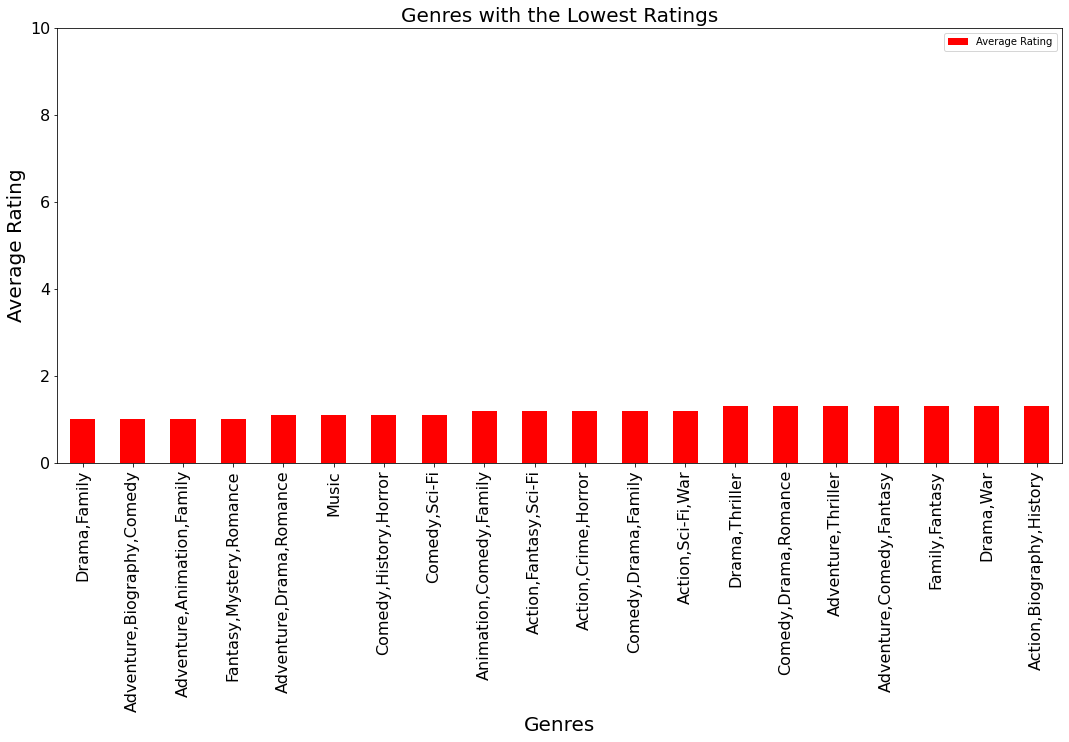

In [20]:
#plt.figure(figsize=(18, 5))
#plt.bar(top_30["genres"], top_30["avg_rating"], color = "b")

top_20_no_numvotes_low.plot("genres", kind="bar", figsize = (18,8), color = "r")
plt.xlabel("Genres", fontsize = 20)
plt.xticks(rotation = 90, fontsize = 16)
plt.ylabel("Average Rating", fontsize = 20)
plt.yticks(range(0,11,2), fontsize = 16)
plt.title("Genres with the Lowest Ratings", fontsize = 20)
plt.legend(labels=['Average Rating'])
plt.show()